# Samuel Shiao

#### Imports

In [1]:
import numpy as np
import pandas as pd
import nltk

from nltk.stem import PorterStemmer
from dict import contractions, stop_words

from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from nltk.corpus import stopwords

from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Constants

In [2]:
# Reproducibility
np.random.seed(1234)

MAX_SEQUENCE_LENGTH = 5000
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.15

## Section 1: Load Data

#### File Paths

In [3]:
TRAIN_CSV = 'train.csv'
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'

In [4]:
train_df = pd.read_csv(TRAIN_CSV)

In [5]:
train_df.head(10)

,Genre,Lyrics
0,Happy,Evening shadows make me blue When each weary d...
1,Happy,Ohhhhh ohhhhhh ohhhhhh ohhhhhhh Oh her eyes h...
2,Happy,[Ja Rule] Woo ha ha right back at ya.. its t...
3,Happy,Good times These are the good times Leave your...
4,Happy,You were a child Crawling on your knees toward...
5,Happy,I never thought that you would be the one to h...
6,Happy,Beauty queen of only eighteen She had some tro...
7,Happy,Tell me we dont have to leave Say we can stay ...
8,Happy,Sunday morning rain is falling Steal some cove...
9,Happy,Isnt it a little late Shouldnt you fly away Li...


## Section 2: Data Processing

From Practical 4 Code:
In this section we will proccess our data into a format suitable for inputting into a LSTM or more specifically, a Siamese LSTM. The general structure we will follow is:

1. Preprocess the text (clean it up)
2. Tokenize every word in the text (replace each word with an index number)
3. Pad every sequence of indices with zeros to make them all the same length
4. Build an embedding matrix that we can use to look up every indices word embedding

In [6]:
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

### Preprocessing

Please preprocess the text. This is a standard practice to make sure that the text isn't noisy. Some examples of what you can do here are:

* Removing stop words
* Removing punctuation
* Getting rid of stuff like "what's" and making it "what is'
* Stemming words so they are all the same tense (e.g. ran -> run)

In [7]:
ps = PorterStemmer()
punctuation = ["\"", "?", "!", ".", ","]

def clean_text(text):
    text = str(text)
    
    #Replace stop words
    #for w in stop_words:
    #    text = text.replace(" " + w + " ", " ")
        
    words = [x for x in "i am the cop".split() if x not in stop_words]
    #expanding contractions
    words = text.split()
    
    text = ""
    for w in words:
        if(str(w) in contractions):
            text = text + contractions[w] + " "
        else:
            text = text + w + " "
    text = text.strip() #to remove that last space at the end
    
    #Replace punctuation
    for w in punctuation:
        text = text.replace(w, "")
    
    #change verb tenses
    words = text.split()
    text = ""
    for w in words:
        text = text + str(ps.stem(w)) + " "
    
    # Return type should be str
    return text;

In [8]:
#testing clean_text

test1 = "This is a basic sentence including normal syntax, but it has a few stop words in it. having have had flew fly flying"
test2 = "This sentence has more than just a few basic stop words! as if it were he they no top?? run running ran runner buying bought buy sought seek saw"
test3 = "running runner ran runs flying flyer fly flies flight you've i'd he'd we'd"


print(test1)
print(clean_text(test1))
print("\n")

print(test2)
print(clean_text(test2))
print("\n")

print(test3)
print(clean_text(test3))
print("\n")


This is a basic sentence including normal syntax, but it has a few stop words in it. having have had flew fly flying
thi is a basic sentenc includ normal syntax but it ha a few stop word in it have have had flew fli fli 


This sentence has more than just a few basic stop words! as if it were he they no top?? run running ran runner buying bought buy sought seek saw
thi sentenc ha more than just a few basic stop word as if it were he they no top run run ran runner buy bought buy sought seek saw 


running runner ran runs flying flyer fly flies flight you've i'd he'd we'd
run runner ran run fli flyer fli fli flight you have i would he had we would 




Applying the preprocessing `clean_text` function to every element in the training and testing data.

In [9]:
lyrics = [clean_text(x) for x in train_df['Lyrics']]
labels = train_df['Genre']
print('Loaded Training Data')

Loaded Training Data


### Tokenizer

To avoid manually having to assign indices and filtering out unfrequent words, we can use a Tokenizer to do this for us. It essentially creates a map of every unique word and an assigned index to it. We specify a parameter called `num_words` which says to only care about the top 20000 most frequent words. 

In [10]:
MAX_NB_WORDS = 20000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(lyrics)
print('Finished Building Tokenizer')

Finished Building Tokenizer


Applying the tokenizer to the training and testing data.

In [11]:
train_sequences_1 = tokenizer.texts_to_sequences(lyrics)
print('Finished Tokenizing Training')

#test_sequences_1 = tokenizer.texts_to_sequences(X_test_1)
#test_sequences_2 = tokenizer.texts_to_sequences(X_test_2)
#print('Finished Tokenizing Testing')

Finished Tokenizing Training


Number of unique words in tokenizer. Has to be <= 20,000.

In [12]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 3539 unique tokens


Pad sequences all to the same length of 30 words.

In [13]:
train_data_1 = pad_sequences(train_sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
#train_data_2 = pad_sequences(train_sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(labels)
print('Shape of data tensor:', train_data_1.shape)
print('Shape of label tensor:', labels.shape)
print('Finished Padding Training')

#test_data_1 = pad_sequences(test_sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
#test_data_2 = pad_sequences(test_sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
#print('Finished Padding Testing')

Shape of data tensor: (226, 5000)
Shape of label tensor: (226,)
Finished Padding Training


### Embedding Matrix

The embedding matrix is a `n x m` matrix where `n` is the number of words and `m` is the dimension of the embedding. In our case, `m=300` and `n=20000`. We take the min between the number of unique words in our tokenizer and max words in case there are less unique words than the max we specified. 

Row `i` in the matrix should contain the embedding of the word with index `i` in the tokenizer. An easy way to create this would be to iterate over `word_index.items()` which gives you the word and it's index. Keep in mind that you can't generate an embedding for a word not in your word2vec model vocabulary.

In [14]:
embedding_matrix = np.zeros((MAX_NB_WORDS, EMBEDDING_DIM))
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding

#questions_cols = ['question1', 'question2']

for dataset in [train_df]:#, test_df]:
# Iterate over the questions only of both training and test datasets
    for index, row in dataset.iterrows():

        q2n = []  # q2n -> question numbers representation
        for word in clean_text(row['Lyrics']):


            if word not in vocabulary:
                vocabulary[word] = len(inverse_vocabulary)
                q2n.append(len(inverse_vocabulary))
                inverse_vocabulary.append(word)
            else:
                q2n.append(vocabulary[word])

        # Replace questions as word to question as number representation
        dataset.set_value(index, 'Lyrics', q2n)
            
embedding_matrix = 1 * np.random.randn(len(vocabulary) + 1, EMBEDDING_DIM)  # This will be the embedding matrix
embedding_matrix[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embedding_matrix[index] = word2vec.word_vec(word)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


### Formatting Data

Here we just format the data into each half for the input (left and right). There is no code to write here but understand what it is doing.

In [15]:
# Random shuffle
perm = np.random.permutation(len(train_data_1))
idx_train = perm[:int(len(train_data_1)*(1-VALIDATION_SPLIT))]
idx_val = perm[int(len(train_data_1)*(1-VALIDATION_SPLIT)):]

data_1_train = train_data_1[idx_train]#, train_data_2[idx_train]))
labels_train = []
for label in labels[idx_train]:
    if(label == 'Happy'):
        labels_train.append([0, 1, 0])
    elif(label == 'Sad'):
        labels_train.append([1, 0, 0])
    else:
        labels_train.append([0, 0, 1])
    
labels_train = np.array(labels_train)
print('Finished Creating Training Data')

#data_1_val = np.vstack((train_data_1[idx_val], train_data_2[idx_val]))
#labels_val = np.concatenate((labels[idx_val], labels[idx_val]))
#print('Finished Creating Validation Data')

Finished Creating Training Data


## Section 3: Building the Model

In this section you will write code to build the actual Siamese network. It should take in two arguments (question1 and question2) and then output a single number representing the probability that the two questions are duplicates.

The model should take in each input sentence, replace it with it's embeddings, then run the new embedding vector through a LSTM layer. The output of each LSTM layer should be concatenated together and then a standard Dense model can be used.

Make sure to note that you should only use one LSTM layer that is shared by both the left and the right half. 

Make sure to title your output layers as `predictions`.

### Build Model

In [16]:
lyric_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

model = Sequential()
model.add(Embedding(20000, 128,input_length = 5000))
model.add(LSTM(196, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.4))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

#predictions = model.predict(data_1_train.reshape(1,5000),batch_size=1,verbose = 2)[0]
#model.add(LSTM(20000, return_sequences=True))
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(10, activation='softmax'))
#model.add(Activation('softmax'))

#embedding
#LSTM
#hidden1
#hidden2
#hidden3
#dense
#output


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5000, 128)         2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 196)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 591       
Total params: 2,815,391
Trainable params: 2,815,391
Non-trainable params: 0
_________________________________________________________________
None


### Compiling Model

In [17]:
#model = Model(inputs=lyric_input, outputs=predictions)
#model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])

In [18]:
data_1_train.shape

(192, 5000)

## Section 4: Training the Model

In this section we will simply train the model. We use the Early Stopping argument to end training if the loss or accuracy don't improve within 3 epochs.

Since the training time is incredibly long (30 minutes or so on a CPU), only train it for one epoch if you don't have time. For better results, train it to around 50 epochs.

In [19]:
labels_train[0]

array([1, 0, 0])

In [20]:
#early_stop = EarlyStopping(monitor='val_loss', patience=3)

hist = model.fit([data_1_train], labels_train, \
        epochs=50, batch_size=2048, shuffle=True)

Epoch 1/50
192/192 [==============================] - 54s 280ms/step - loss: 1.0988 - acc: 0.3281
Epoch 2/50
192/192 [==============================] - 55s 288ms/step - loss: 1.0933 - acc: 0.3854
Epoch 3/50
192/192 [==============================] - 55s 284ms/step - loss: 1.0865 - acc: 0.5052
Epoch 4/50
192/192 [==============================] - 54s 284ms/step - loss: 1.0801 - acc: 0.4948
Epoch 5/50
192/192 [==============================] - 55s 288ms/step - loss: 1.0729 - acc: 0.4948
Epoch 6/50
192/192 [==============================] - 54s 284ms/step - loss: 1.0604 - acc: 0.4948
Epoch 7/50
192/192 [==============================] - 54s 284ms/step - loss: 1.0453 - acc: 0.4375
Epoch 8/50
192/192 [==============================] - 55s 286ms/step - loss: 1.0313 - acc: 0.4427
Epoch 9/50
192/192 [==============================] - 55s 288ms/step - loss: 1.0192 - acc: 0.4271
Epoch 10/50
192/192 [==============================] - 55s 286ms/step - loss: 0.9929 - acc: 0.4427
Epoch 11/50
192/192

### Results

In [21]:
test_df = pd.read_csv('test.csv')
testlyrics = [clean_text(x) for x in test_df['Lyrics']]
testlabels = test_df['Genre']
labels_test = []
for label in testlabels:
    if(label == 'Happy'):
        labels_test.append([0, 1, 0])
    elif(label == 'Sad'):
        labels_test.append([1, 0, 0])
    else:
        labels_test.append([0, 0, 1])

labels_test = np.array(labels_test)
testlyrics = np.array(testlyrics)
                     
test_sequences_1 = tokenizer.texts_to_sequences(testlyrics)
test_data_1 = pad_sequences(test_sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
#print('Loaded Testing Data')

y_pred = model.predict(test_data_1, verbose=1)

15/15 [==============================] - 2s 138ms/step


In [22]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_test_class = np.argmax(labels_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

accuracy = accuracy_score(y_test_class, y_pred_class)
print(accuracy)

0.5333333333333333


In [23]:
print(classification_report(y_test_class,y_pred_class))

             precision    recall  f1-score   support

          0       0.44      0.80      0.57         5
          1       0.75      0.60      0.67         5
          2       0.50      0.20      0.29         5

avg / total       0.56      0.53      0.51        15



In [24]:
import matplotlib.pyplot as plt
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cnf_matrix = confusion_matrix(y_test_class,y_pred_class)
np.set_printoptions(precision=2)

Confusion matrix, without normalization


Confusion matrix, without normalization


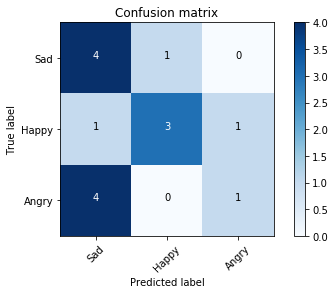

In [25]:

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Sad', 'Happy', 'Angry'], title='Confusion matrix')